In [7074]:
import numpy as np
import pandas as pd
import datetime as dt
from pathlib import Path
import matplotlib.pyplot as plt #graphics
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# Regression Analysis: Seasonal Effects with Sklearn Linear Regression
In this notebook, you will build a SKLearn linear regression model to predict Yen futures ("settle") returns with *lagged* Yen futures returns. 

In [7075]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
yen_futures = pd.read_csv(
    Path("yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


In [7076]:
# Trim the dataset to begin on January 1st, 1990
yen_futures = yen_futures.loc["1990-01-01":, :]
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336.0,51473.0
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206.0,53860.0
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763.0,52072.0


# Data Preparation

### Returns

In [7077]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns = (yen_futures[["Settle"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()

,Settle
Date,
2019-10-09,-0.410601
2019-10-10,-0.369458
2019-10-11,-0.564304
2019-10-14,0.151335
2019-10-15,-0.469509


In [7078]:
returns.head()

,Settle
Date,
1990-01-03,0.584197
1990-01-04,1.756933
1990-01-05,-0.827626
1990-01-08,0.129496
1990-01-09,-0.632275


In [7079]:
yen_futures['Return'] = returns.copy()

### Lagged Returns 

In [7080]:
# Create a lagged return using the shift function
yen_futures['Lagged_Return'] = yen_futures.Return.shift()
# yen_futures = yen_futures.dropna() will drop all data until 2014 as Change started to appear in the dataset column
yen_futures.tail()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest,Return,Lagged_Return
Date,,,,,,,,,,
2019-10-09,9381.0,9391.5,9330.5,9343.5,38.5,9338.0,99153.0,145470.0,-0.410601,0.170931
2019-10-10,9343.5,9380.5,9293.5,9301.0,34.5,9303.5,159397.0,144474.0,-0.369458,-0.410601
2019-10-11,9308.5,9309.0,9240.0,9267.0,52.5,9251.0,158810.0,147471.0,-0.564304,-0.369458
2019-10-14,9259.0,9292.0,9250.5,9261.0,14.0,9265.0,69457.0,153902.0,0.151335,-0.564304
2019-10-15,9264.5,9280.0,9216.5,9220.0,43.5,9221.5,108342.0,151564.0,-0.469509,0.151335


In [7081]:
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest,Return,Lagged_Return
Date,,,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336.0,51473.0,NaN,NaN
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206.0,53860.0,0.584197,NaN
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0,1.756933,0.584197
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0,-0.827626,1.756933
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763.0,52072.0,0.129496,-0.827626


### Train Test Split

In [7082]:
# Create a train/test split for the data using 2018-2019 for testing and the rest for training
# start from 1990-01-04 to drop rows with NaN in Return or Lagged_Return
train = yen_futures['1990-01-04':'2017-12-31']
test = yen_futures['2018':]

In [7083]:
# Create four dataframes:
# X_train (training set using just the independent variables), X_test (test set of of just the independent variables)
# Y_train (training set using just the "y" variable, i.e., "Futures Return"), Y_test (test set of just the "y" variable):
X_train = train["Lagged_Return"].dropna().to_frame()
X_test = test["Lagged_Return"].dropna().to_frame()
y_train = train["Return"]
y_test = test["Return"]

In [7084]:
X_train.tail()

,Lagged_Return
Date,
2017-12-22,0.084621
2017-12-26,0.118370
2017-12-27,0.118230
2017-12-28,-0.151830
2017-12-29,0.180221


In [7085]:
X_test.head()

,Lagged_Return
Date,
2018-01-02,0.224871
2018-01-03,0.297285
2018-01-04,-0.240479
2018-01-05,-0.213028
2018-01-08,-0.353933


In [7086]:
y_train.head()

Date
1990-01-04    1.756933
1990-01-05   -0.827626
1990-01-08    0.129496
1990-01-09   -0.632275
1990-01-10   -0.404917
Name: Return, dtype: float64

# Linear Regression Model

In [7087]:
# Create a Linear Regression model and fit it to the training data
from sklearn.linear_model import LinearRegression

# Fit a SKLearn linear regression using just the training set (X_train, Y_train):
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

# Make predictions using the Testing Data

Note: We want to evaluate the model using data that it has never seen before, in this case: X_test.

In [7088]:
# Make a prediction of "y" values using just the test dataset
predictions = model.predict(X_test)

In [7089]:
# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
Results = y_test.to_frame()
Results["Predicted Return"] = predictions

In [7090]:
Results.head(2)

,Return,Predicted Return
Date,,
2018-01-02,0.297285,0.003815
2018-01-03,-0.240479,0.003046


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a5a7855d0>,
      dtype=object)

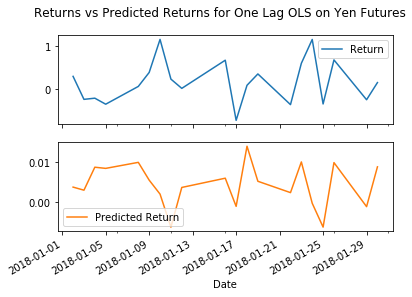

In [7091]:
# Plot the first 20 predictions vs the true values
Results[:20].plot(subplots=True, 
                  title='Returns vs Predicted Returns for One Lag OLS on Yen Futures')

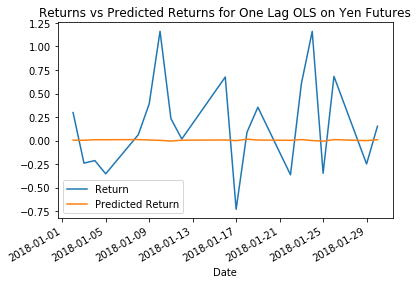

In [7092]:
# Plot the overlayed first 20 predictions vs the true values
Results[:20].plot(title='Returns vs Predicted Returns for One Lag OLS on Yen Futures')

# Out-of-Sample Performance

Evaluate the model using "out-of-sample" data (X_test and y_test)

In [7093]:
from sklearn.metrics import mean_squared_error
# Calculate the mean_squared_error (MSE) on actual versus predicted test "y" 
mse = mean_squared_error(
    Results["Return"],
    Results["Predicted Return"]
)

# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
rmse = np.sqrt(mse)
print(f"Out-of-Sample Root Mean Squared Error (RMSE): {rmse:,.4f}.")

Out-of-Sample Root Mean Squared Error (RMSE): 0.4137.


In [7094]:
from sklearn.metrics import mean_squared_error, r2_score

# Calculate r2_score (r-squared)
r2 = r2_score(y_test, predictions)
print(f"r2: {r2}")

r2: 0.0010352412489498253


Text(0.5, 0.98, 'Out-of-Sample Performance')

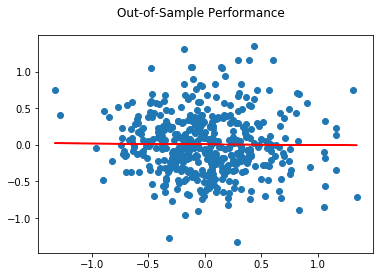

In [7095]:
# Plot X and y as a scatter plot
# Plot X and the predictions as a red line plot
plt.scatter(X_test, y_test)
plt.plot(X_test, predictions, color='red')
plt.suptitle('Out-of-Sample Performance')

# In-Sample Performance

Evaluate the model using in-sample data (X_train and y_train)

In [7096]:
# Construct a dataframe using just the "y" training data:
in_sample_results = y_train.to_frame()

# Add a column of "in-sample" predictions to that dataframe:  
in_sample_results["In-sample Predictions"] = model.predict(X_train)

in_sample_results.head()

,Return,In-sample Predictions
Date,,
1990-01-04,1.756933,-0.000003
1990-01-05,-0.827626,-0.012462
1990-01-08,0.129496,0.014997
1990-01-09,-0.632275,0.004828
1990-01-10,-0.404917,0.012921


In [7097]:
# Calculate in-sample mean_squared_error (for comparison to out-of-sample)
in_sample_mse = mean_squared_error(
    in_sample_results["Return"],
    in_sample_results["In-sample Predictions"]
)

# Calculate in-sample root mean_squared_error (for comparison to out-of-sample)
in_sample_rmse = np.sqrt(in_sample_mse)
print(f"In-sample Root Mean Squared Error (RMSE): {in_sample_rmse:,.4f}.")

In-sample Root Mean Squared Error (RMSE): 0.7059.


In [7098]:
from sklearn.metrics import mean_squared_error, r2_score

# Calculate r2_score (r-squared)
r2 = r2_score(y_train, in_sample_results["In-sample Predictions"])
print(f"r2: {r2}")

r2: 0.00011288383707153127


Text(0.5, 0.98, 'In-Sample Performance')

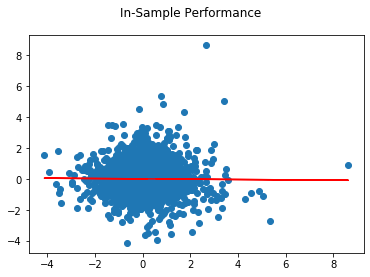

In [7099]:
# Plot X and y as a scatter plot
# Plot X and the predictions as a red line plot
plt.scatter(X_train, y_train)
plt.plot(X_train, in_sample_results["In-sample Predictions"], color='red')
plt.suptitle('In-Sample Performance')

# Conclusions

The root MSEs are 0.4137 for out-of-sample performance and 0.7059 for in-sample performance while R-squares are close to zero, 0.01 and 0.001 respectively, we conclude that the above OLS regression is not a statistically enough to represent the data provided.

# Seasonal Effects

### _Week-of-Year Effects_

In [7100]:
X_train['Week_of_year'] = X_train.index.weekofyear
X_train.head()

,Lagged_Return,Week_of_year
Date,,
1990-01-04,0.584197,1
1990-01-05,1.756933,1
1990-01-08,-0.827626,2
1990-01-09,0.129496,2
1990-01-10,-0.632275,2


In [7101]:
X_test['Week_of_year'] = X_test.index.weekofyear
X_test.head()

,Lagged_Return,Week_of_year
Date,,
2018-01-02,0.224871,1
2018-01-03,0.297285,1
2018-01-04,-0.240479,1
2018-01-05,-0.213028,1
2018-01-08,-0.353933,2


In [7102]:
# Use `get_dummies` to generate the features for each week of the year
X_train_binary_encoded = pd.get_dummies(X_train, columns=['Week_of_year'])
X_train_binary_encoded.head(2)

,Lagged_Return,Week_of_year_1,Week_of_year_2,Week_of_year_3,Week_of_year_4,Week_of_year_5,Week_of_year_6,Week_of_year_7,Week_of_year_8,Week_of_year_9,...,Week_of_year_44,Week_of_year_45,Week_of_year_46,Week_of_year_47,Week_of_year_48,Week_of_year_49,Week_of_year_50,Week_of_year_51,Week_of_year_52,Week_of_year_53
Date,,,,,,,,,,,,,,,,,,,,,
1990-01-04,0.584197,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1990-01-05,1.756933,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7103]:
X_train_binary_encoded.to_clipboard()

In [7104]:
X_test['Week_of_year'] = X_test.index.weekofyear
X_test.head(2)

,Lagged_Return,Week_of_year
Date,,
2018-01-02,0.224871,1
2018-01-03,0.297285,1


In [7105]:
# Use `get_dummies` to generate the features for each week of the year
X_test_binary_encoded = pd.get_dummies(X_test, columns=['Week_of_year'])
X_test_binary_encoded.head(2)

,Lagged_Return,Week_of_year_1,Week_of_year_2,Week_of_year_3,Week_of_year_4,Week_of_year_5,Week_of_year_6,Week_of_year_7,Week_of_year_8,Week_of_year_9,...,Week_of_year_43,Week_of_year_44,Week_of_year_45,Week_of_year_46,Week_of_year_47,Week_of_year_48,Week_of_year_49,Week_of_year_50,Week_of_year_51,Week_of_year_52
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,0.224871,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2018-01-03,0.297285,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7106]:
X_train_binary_encoded.drop(columns='Week_of_year_53', inplace=True)
X_train_binary_encoded.head(2)

,Lagged_Return,Week_of_year_1,Week_of_year_2,Week_of_year_3,Week_of_year_4,Week_of_year_5,Week_of_year_6,Week_of_year_7,Week_of_year_8,Week_of_year_9,...,Week_of_year_43,Week_of_year_44,Week_of_year_45,Week_of_year_46,Week_of_year_47,Week_of_year_48,Week_of_year_49,Week_of_year_50,Week_of_year_51,Week_of_year_52
Date,,,,,,,,,,,,,,,,,,,,,
1990-01-04,0.584197,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1990-01-05,1.756933,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7107]:
# Make sure train and test have the same number of weeks
y_train.drop(columns='Week_of_year_53', inplace=True)
y_train.head(2)

Date
1990-01-04    1.756933
1990-01-05   -0.827626
Name: Return, dtype: float64

In [7108]:
# Create a Linear Regression model and fit it to the data
model_weekly = LinearRegression()
model_weekly.fit(X_train_binary_encoded, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [7109]:
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [7110]:
X_train_binary_encoded.shape

(7062, 53)

In [7111]:
X_test_binary_encoded.shape

(451, 53)

In [7112]:
y_train.shape

(7062,)

In [7113]:
y_test.shape

(451,)

In [7114]:
predictions_weekly = model_weekly.predict(X_test_binary_encoded)
predictions_weekly[:5]

array([-0.05164608, -0.05290401, -0.04356237, -0.04403921,  0.04052882])

In [7115]:
Results_weekly = y_test.to_frame()
Results_weekly["Predicted Return"] = predictions_weekly

In [7116]:
Results_weekly.head(2)

,Return,Predicted Return
Date,,
2018-01-02,0.297285,-0.051646
2018-01-03,-0.240479,-0.052904


#### _Out-of-Sample Performance_

In [7117]:
from sklearn.metrics import mean_squared_error
# Calculate the mean_squared_error (MSE) on actual versus predicted test "y" 
mse_weekly = mean_squared_error(
    Results_weekly["Return"],
    Results_weekly["Predicted Return"]
)

# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
rmse_weekly = np.sqrt(mse_weekly)
print(f"Out-of-Sample Root Mean Squared Error (RMSE): {rmse_weekly:,.4f}.")

Out-of-Sample Root Mean Squared Error (RMSE): 0.4160.


In [7118]:
from sklearn.metrics import mean_squared_error, r2_score

# Calculate r2_score (r-squared)
r2_weekly_outofsample = r2_score(y_test, predictions_weekly)
print(f"r2: {r2_weekly_outofsample}")

r2: -0.010497721548799133


Text(0.5, 0.98, 'Weeks-of-Year Effects on Yen Futures Returns - Out of Sample')

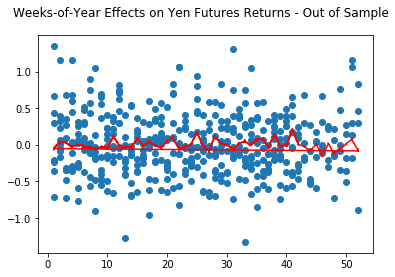

In [7119]:
plt.scatter(X_test['Week_of_year'], y_test)
plt.plot(X_test['Week_of_year'], predictions_weekly, color='red')
plt.suptitle('Weeks-of-Year Effects on Yen Futures Returns - Out of Sample')

#### _In-Sample Performance_

In [7120]:
# Construct a dataframe using just the "y" training data:
in_sample_results_weekly = y_train.to_frame()

# Add a column of "in-sample" predictions to that dataframe:  
in_sample_results_weekly["In-sample Predictions"] = model_weekly.predict(X_train_binary_encoded)

in_sample_results_weekly.head()

,Return,In-sample Predictions
Date,,
1990-01-04,1.756933,-0.057888
1990-01-05,-0.827626,-0.078260
1990-01-08,0.129496,0.048757
1990-01-09,-0.632275,0.032131
1990-01-10,-0.404917,0.045364


In [7121]:
# Calculate in-sample mean_squared_error (for comparison to out-of-sample)
in_sample_mse_weekly = mean_squared_error(
    in_sample_results_weekly["Return"],
    in_sample_results_weekly["In-sample Predictions"]
)

# Calculate in-sample root mean_squared_error (for comparison to out-of-sample)
in_sample_rmse_weekly = np.sqrt(in_sample_mse_weekly)
print(f"In-sample Root Mean Squared Error (RMSE) with week-of-year dummies: {in_sample_rmse_weekly:,.4f}.")

In-sample Root Mean Squared Error (RMSE) with week-of-year dummies: 0.7026.


In [7122]:
from sklearn.metrics import mean_squared_error, r2_score

# Calculate r2_score (r-squared)
r2_weekly_insample = r2_score(y_train, in_sample_results_weekly["In-sample Predictions"])
print(f"r2: {r2_weekly_insample}")

r2: 0.009441708887879652


Text(0.5, 0.98, 'Weeks-of-Year Effects on Yen Futures Returns - In Sample')

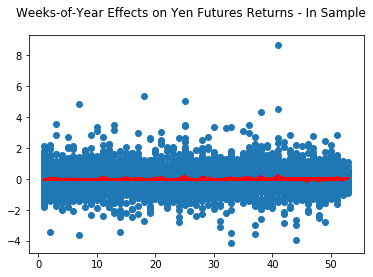

In [7123]:
plt.scatter(X_train['Week_of_year'], y_train)
plt.plot(X_train['Week_of_year'], in_sample_results_weekly["In-sample Predictions"], color='red')
plt.suptitle('Weeks-of-Year Effects on Yen Futures Returns - In Sample')

### _Day-of-Week Effect_

In [7124]:
X_train['Day_of_week'] = X_train.index.dayofweek
X_train.head()

,Lagged_Return,Week_of_year,Day_of_week
Date,,,
1990-01-04,0.584197,1,3
1990-01-05,1.756933,1,4
1990-01-08,-0.827626,2,0
1990-01-09,0.129496,2,1
1990-01-10,-0.632275,2,2


In [7125]:
X_train.drop(columns ='Week_of_year', inplace=True)
X_train.head()

,Lagged_Return,Day_of_week
Date,,
1990-01-04,0.584197,3
1990-01-05,1.756933,4
1990-01-08,-0.827626,0
1990-01-09,0.129496,1
1990-01-10,-0.632275,2


In [7126]:
# Use `get_dummies` to generate the features for each week of the year
X_train_day_encoded = pd.get_dummies(X_train, columns=['Day_of_week'])
X_train_day_encoded.head(2)

,Lagged_Return,Day_of_week_0,Day_of_week_1,Day_of_week_2,Day_of_week_3,Day_of_week_4
Date,,,,,,
1990-01-04,0.584197,0,0,0,1,0
1990-01-05,1.756933,0,0,0,0,1


In [7127]:
X_test['Day_of_week'] = X_test.index.dayofweek
X_test.head(2)

,Lagged_Return,Week_of_year,Day_of_week
Date,,,
2018-01-02,0.224871,1,1
2018-01-03,0.297285,1,2


In [7128]:
X_test.drop(columns ='Week_of_year', inplace=True)
X_test.head(2)

,Lagged_Return,Day_of_week
Date,,
2018-01-02,0.224871,1
2018-01-03,0.297285,2


In [7129]:
X_test_day_encoded = pd.get_dummies(X_test, columns=['Day_of_week'])
X_test_day_encoded.head(2)

,Lagged_Return,Day_of_week_0,Day_of_week_1,Day_of_week_2,Day_of_week_3,Day_of_week_4
Date,,,,,,
2018-01-02,0.224871,0,1,0,0,0
2018-01-03,0.297285,0,0,1,0,0


In [7130]:
# Create a Linear Regression model and fit it to the data
model_daily = LinearRegression()
model_daily.fit(X_train_day_encoded, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [7131]:
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [7132]:
predictions_daily = model_daily.predict(X_test_day_encoded)
predictions_daily[:5]

array([ 0.04461812, -0.02217061,  0.01361645, -0.03293367,  0.03174765])

In [7133]:
Results_daily = y_test.to_frame()
Results_daily["Predicted Return"] = predictions_daily
Results_daily.head(2)

,Return,Predicted Return
Date,,
2018-01-02,0.297285,0.044618
2018-01-03,-0.240479,-0.022171


#### _Out-of-Sample Performance_

In [7134]:
from sklearn.metrics import mean_squared_error

# Calculate the mean_squared_error (MSE) on actual versus predicted test "y" 
mse_daily = mean_squared_error(
    Results_daily["Return"],
    Results_daily["Predicted Return"]
)

# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
rmse_daily_outofsample = np.sqrt(mse_daily)
print(f"Out-of-Sample Root Mean Squared Error (RMSE) for day-of-week effects: {rmse_daily_outofsample:,.4f}.")

Out-of-Sample Root Mean Squared Error (RMSE) for day-of-week effects: 0.4159.


In [7135]:
from sklearn.metrics import mean_squared_error, r2_score

# Calculate r2_score (r-squared)
r2_daily_outofsample = r2_score(y_test, predictions_daily)
print(f"r2: {r2_daily_outofsample}")

r2: -0.009626807365905155


#### _In-Sample Performance_

In [7136]:
# Construct a dataframe using just the "y" training data:
in_sample_results_daily = y_train.to_frame()

# Add a column of "in-sample" predictions to that dataframe:  
in_sample_results_daily["In-sample Predictions"] = model_daily.predict(X_train_day_encoded)

in_sample_results_daily.head(2)

,Return,In-sample Predictions
Date,,
1990-01-04,1.756933,0.005309
1990-01-05,-0.827626,-0.052779


In [7137]:
# Calculate in-sample mean_squared_error (for comparison to out-of-sample)
in_sample_mse_daily = mean_squared_error(
    in_sample_results_daily["Return"],
    in_sample_results_daily["In-sample Predictions"]
)

# Calculate in-sample root mean_squared_error (for comparison to out-of-sample)
in_sample_rmse_daily = np.sqrt(in_sample_mse_daily)
print(f"In-sample Root Mean Squared Error (RMSE) with day-of-week effects: {in_sample_rmse_daily:,.4f}.")

In-sample Root Mean Squared Error (RMSE) with day-of-week effects: 0.7053.


In [7138]:
from sklearn.metrics import mean_squared_error, r2_score

# Calculate r2_score (r-squared)
r2_daily_insample = r2_score(y_train, in_sample_results_daily["In-sample Predictions"])
print(f"r2: {r2_daily_insample}")

r2: 0.0019365507824359307


#### _Effect by Months_

In [7139]:
X_train['Month'] = X_train.index.month
X_train.tail(2)

,Lagged_Return,Day_of_week,Month
Date,,,
2017-12-28,-0.151830,3,12
2017-12-29,0.180221,4,12


In [7140]:
X_train.drop(columns ='Day_of_week', inplace=True)
X_train.head(2)

,Lagged_Return,Month
Date,,
1990-01-04,0.584197,1
1990-01-05,1.756933,1


In [7141]:
X_train_month_encoded = pd.get_dummies(X_train, columns=['Month'])
X_train_month_encoded.head(2)

,Lagged_Return,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
Date,,,,,,,,,,,,,
1990-01-04,0.584197,1,0,0,0,0,0,0,0,0,0,0,0
1990-01-05,1.756933,1,0,0,0,0,0,0,0,0,0,0,0


In [7142]:
X_test['Month'] = X_test.index.month
X_test.tail(2)

,Lagged_Return,Day_of_week,Month
Date,,,
2019-10-14,-0.564304,0,10
2019-10-15,0.151335,1,10


In [7143]:
X_test.drop(columns ='Day_of_week', inplace=True)
X_test.head(2)

,Lagged_Return,Month
Date,,
2018-01-02,0.224871,1
2018-01-03,0.297285,1


In [7144]:
X_test_month_encoded = pd.get_dummies(X_test, columns=['Month'])
X_test_month_encoded.head(2)

,Lagged_Return,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
Date,,,,,,,,,,,,,
2018-01-02,0.224871,1,0,0,0,0,0,0,0,0,0,0,0
2018-01-03,0.297285,1,0,0,0,0,0,0,0,0,0,0,0


In [7145]:
# Create a Linear Regression model and fit it to the data
model_monthly = LinearRegression()
model_monthly.fit(X_train_month_encoded, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [7146]:
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [7147]:
predictions_monthly = model_monthly.predict(X_test_month_encoded)
predictions_monthly[:5]

array([-0.01060121, -0.01147855, -0.00496328, -0.00529585, -0.00358873])

In [7148]:
Results_monthly = y_test.to_frame()
Results_monthly["Predicted Return"] = predictions_monthly
Results_monthly.head(2)

,Return,Predicted Return
Date,,
2018-01-02,0.297285,-0.010601
2018-01-03,-0.240479,-0.011479


In [7149]:
from sklearn.metrics import mean_squared_error

# Calculate the mean_squared_error (MSE) on actual versus predicted test "y" 
mse_monthly = mean_squared_error(
    Results_monthly["Return"],
    Results_monthly["Predicted Return"]
)

# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
rmse_monthly_outofsample = np.sqrt(mse_monthly)
print(f"Out-of-Sample Root Mean Squared Error (RMSE) for monthly effects: {rmse_monthly_outofsample:,.4f}.")

Out-of-Sample Root Mean Squared Error (RMSE) for monthly effects: 0.4152.


In [7150]:
from sklearn.metrics import mean_squared_error, r2_score

# Calculate r2_score (r-squared)
r2_monthly_outofsample = r2_score(y_test, predictions_monthly)
print(f"r2: {r2_monthly_outofsample}")

r2: -0.006400741864484472


In [7151]:
# Construct a dataframe using just the "y" training data:
in_sample_results_monthly = y_train.to_frame()

# Add a column of "in-sample" predictions to that dataframe:  
in_sample_results_monthly["In-sample Predictions"] = model_monthly.predict(X_train_month_encoded)

in_sample_results_monthly.head(2)

,Return,In-sample Predictions
Date,,
1990-01-04,1.756933,-0.014955
1990-01-05,-0.827626,-0.029163


In [7152]:
# Calculate in-sample mean_squared_error (for comparison to out-of-sample)
in_sample_mse_monthly = mean_squared_error(
    in_sample_results_monthly["Return"],
    in_sample_results_monthly["In-sample Predictions"]
)

# Calculate in-sample root mean_squared_error (for comparison to out-of-sample)
in_sample_rmse_monthly = np.sqrt(in_sample_mse_monthly)
print(f"In-sample Root Mean Squared Error (RMSE) with monthly effects: {in_sample_rmse_monthly:,.4f}.")

In-sample Root Mean Squared Error (RMSE) with monthly effects: 0.7055.


In [7153]:
from sklearn.metrics import mean_squared_error, r2_score

# Calculate r2_score (r-squared)
r2_monthly_insample = r2_score(y_train, in_sample_results_monthly["In-sample Predictions"])
print(f"r2: {r2_monthly_insample}")

r2: 0.0014511143095583545


### _Seasonal Effects_

In [7154]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
 
# Integer Encoding
label_encoder = LabelEncoder()

In [7155]:
# Fitting the label encoder
label_encoder.fit(X_train["Month"])

LabelEncoder()

In [7156]:
list(label_encoder.classes_)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [7157]:
seasons = [1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 1]

In [7158]:
month_to_season = dict(zip(range(1,13), seasons))

In [7159]:
month_to_season 

{1: 1, 2: 1, 3: 2, 4: 2, 5: 2, 6: 3, 7: 3, 8: 3, 9: 4, 10: 4, 11: 4, 12: 1}

In [7160]:
X_train['Season'] = X_train.Month.map(month_to_season) 
X_train.head(2)

,Lagged_Return,Month,Season
Date,,,
1990-01-04,0.584197,1,1
1990-01-05,1.756933,1,1


In [7161]:
X_train.drop(['Month'], axis=1, inplace=True)
X_train.head(2)

,Lagged_Return,Season
Date,,
1990-01-04,0.584197,1
1990-01-05,1.756933,1


In [7162]:
X_test['Season'] = X_test.Month.map(month_to_season) 
X_test.head(2)

,Lagged_Return,Month,Season
Date,,,
2018-01-02,0.224871,1,1
2018-01-03,0.297285,1,1


In [7163]:
X_test.drop(['Month'], axis=1, inplace=True)
X_test.head(2)

,Lagged_Return,Season
Date,,
2018-01-02,0.224871,1
2018-01-03,0.297285,1


### _Dummy Encoding (Binary Encoded Data)_

In [7164]:
X_train_season_encoded = pd.get_dummies(X_train, columns=['Season'])
X_train_season_encoded.head(2)

,Lagged_Return,Season_1,Season_2,Season_3,Season_4
Date,,,,,
1990-01-04,0.584197,1,0,0,0
1990-01-05,1.756933,1,0,0,0


In [7165]:
X_test_season_encoded = pd.get_dummies(X_test, columns=['Season'])
X_test_season_encoded.head(2)

,Lagged_Return,Season_1,Season_2,Season_3,Season_4
Date,,,,,
2018-01-02,0.224871,1,0,0,0
2018-01-03,0.297285,1,0,0,0


In [7166]:
# Create a Linear Regression model and fit it to the data
model_seasonal = LinearRegression()
model_seasonal.fit(X_train_season_encoded, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [7167]:
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [7168]:
predictions_seasonal = model_seasonal.predict(X_test_season_encoded)
predictions_seasonal[:5]

array([-0.00878715, -0.0095717 , -0.00374543, -0.00404284, -0.00251624])

In [7169]:
Results_seasonal = y_test.to_frame()
Results_seasonal["Predicted Return"] = predictions_seasonal
Results_seasonal.head(2)

,Return,Predicted Return
Date,,
2018-01-02,0.297285,-0.008787
2018-01-03,-0.240479,-0.009572


In [7170]:
from sklearn.metrics import mean_squared_error

# Calculate the mean_squared_error (MSE) on actual versus predicted test "y" 
mse_seasonal_outofsample = mean_squared_error(
    Results_seasonal["Return"],
    Results_seasonal["Predicted Return"]
)

# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
rmse_seasonal_outofsample = np.sqrt(mse_seasonal_outofsample)
print(f"Out-of-Sample Root Mean Squared Error (RMSE) for seasonal effects: {rmse_seasonal_outofsample:,.4f}.")

Out-of-Sample Root Mean Squared Error (RMSE) for seasonal effects: 0.4142.


In [7171]:
# Calculate r2_score (r-squared)
r2_seasonal_outofsample = r2_score(y_test, predictions_seasonal)
print(f"r2: {r2_seasonal_outofsample:,.4f}")

r2: -0.0016


In [7172]:
# Construct a dataframe using just the "y" training data:
in_sample_results_seasonal = y_train.to_frame()

# Add a column of "in-sample" predictions to that dataframe:  
in_sample_results_seasonal["In-sample Predictions"] = model_seasonal.predict(X_train_season_encoded)

in_sample_results_seasonal.head(2)

,Return,In-sample Predictions
Date,,
1990-01-04,1.756933,-0.012680
1990-01-05,-0.827626,-0.025386


In [7173]:
# Calculate in-sample mean_squared_error (for comparison to out-of-sample)
in_sample_mse_seasonal = mean_squared_error(
    in_sample_results_seasonal["Return"],
    in_sample_results_seasonal["In-sample Predictions"]
)

# Calculate in-sample root mean_squared_error (for comparison to out-of-sample)
in_sample_rmse_seasonal = np.sqrt(in_sample_mse_seasonal)
print(f"In-sample Root Mean Squared Error (RMSE) with seasonal effects: {in_sample_rmse_seasonal:,.4f}.")

In-sample Root Mean Squared Error (RMSE) with seasonal effects: 0.7059.


In [7174]:
# Calculate r2_score (r-squared)
r2_seasonal_insample = r2_score(y_train, in_sample_results_seasonal["In-sample Predictions"])
print(f"r2: {r2_seasonal_insample:,.4f}")

r2: 0.0004


### _Recode Seasons into summer_winter Binaries_

In [7175]:
summer_winter = [1, 0, 0, 1]

In [7176]:
season_to_summer_winter = dict(zip(range(1,5), summer_winter))

In [7177]:
season_to_summer_winter

{1: 1, 2: 0, 3: 0, 4: 1}

In [7178]:
X_train['summer_winter'] = X_train.Season.map(season_to_summer_winter) 
X_train.head(2)

,Lagged_Return,Season,summer_winter
Date,,,
1990-01-04,0.584197,1,1
1990-01-05,1.756933,1,1


In [7179]:
X_train_summer_winter = X_train.drop(['Season'], axis=1)
X_train_summer_winter.head(2)

,Lagged_Return,summer_winter
Date,,
1990-01-04,0.584197,1
1990-01-05,1.756933,1


In [7180]:
X_test['summer_winter'] = X_test.Season.map(season_to_summer_winter) 
X_test.head(2)

,Lagged_Return,Season,summer_winter
Date,,,
2018-01-02,0.224871,1,1
2018-01-03,0.297285,1,1


In [7181]:
X_test_summer_winter = X_test.drop(['Season'], axis=1)

In [7182]:
X_test_summer_winter.head(2)

,Lagged_Return,summer_winter
Date,,
2018-01-02,0.224871,1
2018-01-03,0.297285,1


#### _Binary Encode by Summer and Winter_

In [7183]:
X_train_summer_winter_encoded = pd.get_dummies(X_train_summer_winter, columns=['summer_winter'])
X_train_summer_winter_encoded.head(2)

,Lagged_Return,summer_winter_0,summer_winter_1
Date,,,
1990-01-04,0.584197,0,1
1990-01-05,1.756933,0,1


In [7184]:
X_test_summer_winter_encoded = pd.get_dummies(X_test_summer_winter, columns=['summer_winter'])
X_test_summer_winter_encoded.head(2)

,Lagged_Return,summer_winter_0,summer_winter_1
Date,,,
2018-01-02,0.224871,0,1
2018-01-03,0.297285,0,1


In [7185]:
# Create a Linear Regression model and fit it to the data
model_summer_winter = LinearRegression()
model_summer_winter.fit(X_train_summer_winter_encoded, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [7186]:
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [7187]:
predictions_summer_winter = model_summer_winter.predict(X_test_summer_winter_encoded)
predictions_summer_winter[:5]

array([-0.0048293 , -0.005608  ,  0.0001748 , -0.00012039,  0.00139481])

In [7188]:
Results_summer_winter = y_test.to_frame()
Results_summer_winter["Predicted Return"] = predictions_summer_winter
Results_summer_winter.head(2)

,Return,Predicted Return
Date,,
2018-01-02,0.297285,-0.004829
2018-01-03,-0.240479,-0.005608


In [7189]:
from sklearn.metrics import mean_squared_error

# Calculate the mean_squared_error (MSE) on actual versus predicted test "y" 
mse_summer_winter_outofsample = mean_squared_error(
    Results_seasonal["Return"],
    Results_seasonal["Predicted Return"]
)

# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
rmse_summer_winter_outofsample = np.sqrt(mse_summer_winter_outofsample)
print(f"Out-of-Sample Root Mean Squared Error (RMSE) for effects of summers and winters: {rmse_summer_winter_outofsample:,.4f}.")

Out-of-Sample Root Mean Squared Error (RMSE) for effects of summers and winters: 0.4142.


In [7190]:
# Calculate r2_score (r-squared)
r2_summer_winter_outofsample = r2_score(y_test, predictions_summer_winter)
print(f"r2: {r2_summer_winter_outofsample:,.4f}")

r2: 0.0001


In [7191]:
# Construct a dataframe using just the "y" training data:
in_sample_results_summer_winter = y_train.to_frame()

# Add a column of "in-sample" predictions to that dataframe:  
in_sample_results_summer_winter["In-sample Predictions"] = model_summer_winter.predict(X_train_summer_winter_encoded)

in_sample_results_summer_winter.head(2)

,Return,In-sample Predictions
Date,,
1990-01-04,1.756933,-0.008693
1990-01-05,-0.827626,-0.021304


In [7192]:
# Calculate in-sample mean_squared_error (for comparison to out-of-sample)
in_sample_mse_summer_winter = mean_squared_error(
    in_sample_results_summer_winter["Return"],
    in_sample_results_summer_winter["In-sample Predictions"]
)

# Calculate in-sample root mean_squared_error (for comparison to out-of-sample)
in_sample_rmse_summer_winter = np.sqrt(in_sample_mse_summer_winter)
print(f"In-sample Root Mean Squared Error (RMSE) with effects of summers and winters: {in_sample_rmse_summer_winter:,.4f}.")

In-sample Root Mean Squared Error (RMSE) with effects of summers and winters: 0.7059.


In [7193]:
# Calculate r2_score (r-squared)
r2_summer_winter_insample = r2_score(y_train, in_sample_results_summer_winter["In-sample Predictions"])
print(f"r2: {r2_summer_winter_insample:,.4f}")

r2: 0.0003


### _Effect of Travel Season in Fall_

In [7194]:
fall = [0, 0, 1, 0]

In [7195]:
season_to_fall = dict(zip(range(1,5), fall))

In [7196]:
season_to_fall

{1: 0, 2: 0, 3: 1, 4: 0}

In [7197]:
X_train['fall'] = X_train.Season.map(summer_winter_to_fall) 
X_train.head()

,Lagged_Return,Season,summer_winter,fall
Date,,,,
1990-01-04,0.584197,1,1,0
1990-01-05,1.756933,1,1,0
1990-01-08,-0.827626,1,1,0
1990-01-09,0.129496,1,1,0
1990-01-10,-0.632275,1,1,0


In [7198]:
X_train_fall = X_train.drop(['summer_winter','Season'], axis=1)
X_train_fall.head(2)

,Lagged_Return,fall
Date,,
1990-01-04,0.584197,0
1990-01-05,1.756933,0


In [7199]:
X_test['fall'] = X_test.Season.map(summer_winter_to_fall) 
X_test.tail(2)

,Lagged_Return,Season,summer_winter,fall
Date,,,,
2019-10-14,-0.564304,4,1,0
2019-10-15,0.151335,4,1,0


In [7200]:
X_test_fall = X_test.drop(['summer_winter','Season'], axis=1)
X_test_fall.head(2)

,Lagged_Return,fall
Date,,
2018-01-02,0.224871,0
2018-01-03,0.297285,0


In [7201]:
X_test_fall.iloc[165:170]

,Lagged_Return,fall
Date,,
2018-08-28,0.088844,1
2018-08-29,-0.116505,1
2018-08-30,-0.427683,1
2018-08-31,0.568974,1
2018-09-04,0.027733,0


#### _Binary Encode by Summer and Winter_

In [7202]:
X_train_fall_encoded = pd.get_dummies(X_train_fall, columns=['fall'])
X_train_fall_encoded.head(2)

,Lagged_Return,fall_0,fall_1
Date,,,
1990-01-04,0.584197,1,0
1990-01-05,1.756933,1,0


In [7203]:
X_test_fall_encoded = pd.get_dummies(X_test_fall, columns=['fall'])
X_test_fall_encoded.head(2)

,Lagged_Return,fall_0,fall_1
Date,,,
2018-01-02,0.224871,1,0
2018-01-03,0.297285,1,0


#### _Fit into a Regression_

In [7204]:
# Create a Linear Regression model and fit it to the data
model_fall = LinearRegression()
model_fall.fit(X_train_fall_encoded, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [7205]:
predictions_fall = model_fall.predict(X_test_fall_encoded)
predictions_fall[:5]

array([-0.00219638, -0.00297703,  0.00282021,  0.00252429,  0.00404327])

In [7206]:
Results_fall = y_test.to_frame()
Results_fall["Predicted Return"] = predictions_fall
Results_fall.head(2)

,Return,Predicted Return
Date,,
2018-01-02,0.297285,-0.002196
2018-01-03,-0.240479,-0.002977


In [7207]:
from sklearn.metrics import mean_squared_error

# Calculate the mean_squared_error (MSE) on actual versus predicted test "y" 
mse_fall_outofsample = mean_squared_error(
    Results_fall["Return"],
    Results_fall["Predicted Return"]
)

# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
rmse_fall_outofsample = np.sqrt(mse_fall_outofsample)
print(f"Out-of-Sample Root Mean Squared Error (RMSE) for effects of fall travel season: {rmse_fall_outofsample:,.4f}.")

Out-of-Sample Root Mean Squared Error (RMSE) for effects of fall travel season: 0.4139.


In [7208]:
# Calculate r2_score (r-squared)
r2_fall_outofsample = r2_score(y_test, predictions_fall)
print(f"r2: {r2_fall_outofsample:,.4f}")

r2: -0.0003


In [7209]:
# Construct a dataframe using just the "y" training data:
in_sample_results_fall = y_train.to_frame()

# Add a column of "in-sample" predictions to that dataframe:  
in_sample_results_fall["In-sample Predictions"] = model_fall.predict(X_train_fall_encoded)

in_sample_results_fall.head(2)

,Return,In-sample Predictions
Date,,
1990-01-04,1.756933,-0.006070
1990-01-05,-0.827626,-0.018712


In [7210]:
# Calculate in-sample mean_squared_error (for comparison to out-of-sample)
in_sample_mse_fall = mean_squared_error(
    in_sample_results_fall["Return"],
    in_sample_results_fall["In-sample Predictions"]
)

# Calculate in-sample root mean_squared_error (for comparison to out-of-sample)
in_sample_rmse_fall = np.sqrt(in_sample_mse_fall)
print(f"In-sample Root Mean Squared Error (RMSE) with effects of fall travel season: {in_sample_rmse_fall:,.4f}.")

In-sample Root Mean Squared Error (RMSE) with effects of fall travel season: 0.7059.


In [7211]:
# Calculate r2_score (r-squared)
r2_fall_insample = r2_score(y_train, in_sample_results_fall["In-sample Predictions"])
print(f"r2: {r2_fall_insample:,.4f}")

r2: 0.0003


### _Rolling OLS Regression Model_

In [7212]:
# Set a seasonal dataframe and drop days that does not have either Return or Lagged_Return
yen_futures_seasonal = yen_futures['1990-01-04':]
yen_futures_seasonal['Month'] = yen_futures_seasonal.index.month

# Set index to 'Month' and map seasons to months as previously defined
yen_futures_seasonal['Season'] = yen_futures_seasonal.Month.map(month_to_season) 
yen_futures_seasonal.head(2)

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest,Return,Lagged_Return,Month,Season
Date,,,,,,,,,,,,
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0,1.756933,0.584197,1,1
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0,-0.827626,1.756933,1,1


In [7213]:
yen_futures_seasonal.drop(['Open','High','Low','Last','Change','Volume','Settle','Previous Day Open Interest','Month'], axis=1, inplace=True)
yen_futures_seasonal.head(2)

,Return,Lagged_Return,Season
Date,,,
1990-01-04,1.756933,0.584197,1
1990-01-05,-0.827626,1.756933,1


**_Set DateTimeIndex to Month_**

In [7214]:
yen_futures_seasonal.index.to_period("m")

PeriodIndex(['1990-01', '1990-01', '1990-01', '1990-01', '1990-01', '1990-01',
             '1990-01', '1990-01', '1990-01', '1990-01',
             ...
             '2019-10', '2019-10', '2019-10', '2019-10', '2019-10', '2019-10',
             '2019-10', '2019-10', '2019-10', '2019-10'],
            dtype='period[M]', name='Date', length=7513, freq='M')

In [7215]:
yen_futures_seasonal.index[0]

Timestamp('1990-01-04 00:00:00')

In [7216]:
yen_futures_seasonal.index[0].to_period('m')

Period('1990-01', 'M')

In [7217]:
yen_futures_seasonal.index[0].to_period('m').end_time

Timestamp('1990-01-31 23:59:59.999999999')

In [7218]:
months = yen_futures_seasonal.index.to_period('m').unique()
months

PeriodIndex(['1990-01', '1990-02', '1990-03', '1990-04', '1990-05', '1990-06',
             '1990-07', '1990-08', '1990-09', '1990-10',
             ...
             '2019-01', '2019-02', '2019-03', '2019-04', '2019-05', '2019-06',
             '2019-07', '2019-08', '2019-09', '2019-10'],
            dtype='period[M]', name='Date', length=358, freq='M')

### _Time Calculations_

In [7219]:
# Seasonal window = 3 quarters = 9 months
training_window_seasonal = 9

In [7220]:
start_of_training_period_seasonal = months[0].start_time.strftime(format="%Y-%m-%d")
start_of_training_period_seasonal

'1990-01-01'

In [7221]:
end_of_training_period_seasonal = months[training_window_seasonal + 0].end_time.strftime(format="%Y-%m-%d")
end_of_training_period_seasonal

'1990-10-31'

In [7222]:
test_season = months[training_window_seasonal + 0 + 1]
test_season

Period('1990-11', 'M')

In [7223]:
# The first day of the test week
start_of_test_season  = test_season.start_time.strftime(format="%Y-%m-%d")
start_of_test_season

'1990-11-01'

In [7224]:
# The last day of the test week
end_of_test_season = test_season.end_time.strftime(format="%Y-%m-%d")
end_of_test_season

'1990-11-30'

In [7225]:
# Training data with just one window
train_seasonal = yen_futures_seasonal[start_of_training_period_seasonal:end_of_training_period_seasonal]
train_seasonal

,Return,Lagged_Return,Season
Date,,,
1990-01-04,1.756933,0.584197,1
1990-01-05,-0.827626,1.756933,1
1990-01-08,0.129496,-0.827626,1
1990-01-09,-0.632275,0.129496,1
1990-01-10,-0.404917,-0.632275,1
...,...,...,...
1990-10-25,-1.126155,1.126040,4
1990-10-26,-0.307141,-1.126155,4
1990-10-29,-0.102696,-0.307141,4


In [7226]:
# Testing data with just one window
test_seasonal = yen_futures_seasonal[start_of_test_season:end_of_test_season]
test_seasonal

,Return,Lagged_Return,Season
Date,,,
1990-11-01,-0.442018,-0.991119,4
1990-11-02,2.167668,-0.442018,4
1990-11-05,0.894683,2.167668,4
1990-11-06,-1.165442,0.894683,4
1990-11-07,-0.563958,-1.165442,4
1990-11-08,-0.786285,-0.563958,4
1990-11-09,0.038976,-0.786285,4
1990-11-12,1.155844,0.038976,4
1990-11-13,-0.975735,1.155844,4


In [7227]:
# Set the training window as 9 months, 36 weeks
# Total timeframe is 321 months
training_window_seasonal = 9*4
timeframe_seasonal = len(months) - training_window_seasonal - 1
timeframe_seasonal

321

In [7228]:
# Construct an empty placeholder DataFrame, with a column named "Out-of-Sample Predictions"
# (Each iteration of the loop, we'll append that week"s predictions to this DataFrame)
all_predictions_seasonal = pd.DataFrame(columns=["Out-of-Sample Predictions_Seasonal"])
all_predictions_seasonal

,Out-of-Sample Predictions_Seasonal


In [7229]:
# Construct a separate empty DataFrame for actual data
all_actuals_seasonal = pd.DataFrame(columns=["Actual Returns_Seasonal"])
all_actuals_seasonal

,Actual Returns_Seasonal


In [7230]:
for i in range(0, timeframe_seasonal):
    
    # Beginning of training window
    start_of_training_period = months[i].start_time.strftime(format="%Y-%m-%d")
    
    # End of training window
    end_of_training_period = months[training_window_seasonal + i].end_time.strftime(format="%Y-%m-%d")

    # Window of test-window data
    test_month = months[training_window_seasonal+i+1]
    
    # String of testing window
    start_of_test_month  = test_month.start_time.strftime(format="%Y-%m-%d")
    end_of_test_month = test_month.end_time.strftime(format="%Y-%m-%d")
    
    train = yen_futures_seasonal[start_of_training_period:end_of_training_period]
    test = yen_futures_seasonal[start_of_test_month:end_of_test_month]
    
    # Create new DataFrames:
    X_train = train["Lagged_Return"].to_frame()
    y_train = train["Return"]
    X_test = test["Lagged_Return"].to_frame()
    y_test = test["Return"]

    model = LinearRegression()
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    
    # Create a temporary DataFrame to hold predictions
    predictions = pd.DataFrame(predictions, index=X_test.index, columns=["Out-of-Sample Predictions_Seasonal"])
    
    # Create a temporary DataFrame of the actual "y"s in the test DataFrame, with column name="Actual Returns": 
    actuals = pd.DataFrame(y_test, index=y_test.index)
    actuals.columns = ["Actual Returns_Seasonal"]  
    
    # Append these two DataFrames (predictions and actuals) to the two master DataFrames built outside the loop
    all_predictions_seasonal = all_predictions_seasonal.append(predictions)
    all_actuals_seasonal = all_actuals_seasonal.append(actuals)

In [7231]:
# Once the loop is done, concatenate (combine) the two DataFrames to a final "Results" DataFrame:    
Results_seasonal = pd.concat([all_actuals_seasonal, all_predictions_seasonal], axis=1)
Results_seasonal.head()

,Actual Returns_Seasonal,Out-of-Sample Predictions_Seasonal
1993-02-01,-0.187243,0.026023
1993-02-02,0.300150,0.023455
1993-02-03,0.199501,0.019245
1993-02-04,-0.074664,0.020114
1993-02-05,0.112080,0.022483


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a5b0623d0>,
      dtype=object)

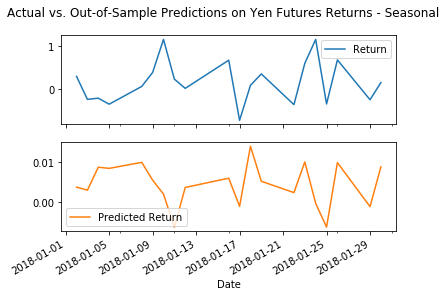

In [7232]:
# Plot the first 20 predictions vs the true values
Results[:20].plot(subplots=True, title='Actual vs. Out-of-Sample Predictions on Yen Futures Returns - Seasonal')

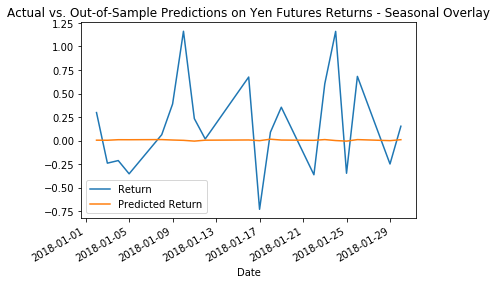

In [7233]:
# Plot the first 20 predictions vs the true values
Results[:20].plot(title='Actual vs. Out-of-Sample Predictions on Yen Futures Returns - Seasonal Overlay')

In [7234]:
mse_seasonal = mean_squared_error(
    Results_seasonal["Actual Returns_Seasonal"],
    Results_seasonal["Out-of-Sample Predictions_Seasonal"]
)

# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
out_of_sample_rmse_seasonal = np.sqrt(mse_seasonal)
print(f"Out-of-Sample Root Mean Squared Error (RMSE) of this seasonal rolling prediction: {out_of_sample_rmse_seasonal:,.4f}")

Out-of-Sample Root Mean Squared Error (RMSE) of this seasonal rolling prediction: 0.6961


In [7235]:
# Calculate r2_score (r-squared)
r2_seasonal_outofsample = r2_score(Results_seasonal["Actual Returns_Seasonal"], Results_seasonal["Out-of-Sample Predictions_Seasonal"])
print(f"r2: {r2_seasonal_outofsample}")

r2: -0.0031790262623399013


### _Rolling 26-Week Predictions_

In [7236]:
yen_futures_seasonal.index.to_period("w")

PeriodIndex(['1990-01-01/1990-01-07', '1990-01-01/1990-01-07',
             '1990-01-08/1990-01-14', '1990-01-08/1990-01-14',
             '1990-01-08/1990-01-14', '1990-01-08/1990-01-14',
             '1990-01-08/1990-01-14', '1990-01-15/1990-01-21',
             '1990-01-15/1990-01-21', '1990-01-15/1990-01-21',
             ...
             '2019-09-30/2019-10-06', '2019-09-30/2019-10-06',
             '2019-09-30/2019-10-06', '2019-10-07/2019-10-13',
             '2019-10-07/2019-10-13', '2019-10-07/2019-10-13',
             '2019-10-07/2019-10-13', '2019-10-07/2019-10-13',
             '2019-10-14/2019-10-20', '2019-10-14/2019-10-20'],
            dtype='period[W-SUN]', name='Date', length=7513, freq='W-SUN')

In [7237]:
weeks = yen_futures_seasonal.index.to_period('w').unique()
weeks

PeriodIndex(['1990-01-01/1990-01-07', '1990-01-08/1990-01-14',
             '1990-01-15/1990-01-21', '1990-01-22/1990-01-28',
             '1990-01-29/1990-02-04', '1990-02-05/1990-02-11',
             '1990-02-12/1990-02-18', '1990-02-19/1990-02-25',
             '1990-02-26/1990-03-04', '1990-03-05/1990-03-11',
             ...
             '2019-08-12/2019-08-18', '2019-08-19/2019-08-25',
             '2019-08-26/2019-09-01', '2019-09-02/2019-09-08',
             '2019-09-09/2019-09-15', '2019-09-16/2019-09-22',
             '2019-09-23/2019-09-29', '2019-09-30/2019-10-06',
             '2019-10-07/2019-10-13', '2019-10-14/2019-10-20'],
            dtype='period[W-SUN]', name='Date', length=1555, freq='W-SUN')

In [7238]:
# Set the training window as 26 weeks, i.e. half a year or 6.5 months
# Total timeframe is 1528 weeks
training_window = 26
timeframe = len(weeks) - training_window - 1
timeframe

1528

In [7239]:
# Construct an empty placeholder DataFrame, with a column named "Out-of-Sample Predictions"
# (Each iteration of the loop, we'll append that week"s predictions to this DataFrame)
all_predictions = pd.DataFrame(columns=["Out-of-Sample Predictions"])
all_predictions

,Out-of-Sample Predictions


In [7240]:
# Construct a separate empty DataFrame for actual data
all_actuals = pd.DataFrame(columns=["Actual Returns"])
all_actuals

,Actual Returns


In [7241]:
for i in range(0, timeframe):
    
    # Beginning of training window
    start_of_training_period = weeks[i].start_time.strftime(format="%Y-%m-%d")
    
    # End of training window
    end_of_training_period = weeks[training_window + i].end_time.strftime(format="%Y-%m-%d")

    # Window of test-window data
    test_week = weeks[training_window+i+1]
    
    # String of testing window
    start_of_test_week  = test_week.start_time.strftime(format="%Y-%m-%d")
    end_of_test_week = test_week.end_time.strftime(format="%Y-%m-%d")
    
    train = yen_futures_seasonal[start_of_training_period:end_of_training_period]
    test = yen_futures_seasonal[start_of_test_week:end_of_test_week]
    
    # Create new DataFrames:
    X_train = train["Lagged_Return"].to_frame()
    y_train = train["Return"]
    X_test = test["Lagged_Return"].to_frame()
    y_test = test["Return"]

    model = LinearRegression()
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    
    # Create a temporary DataFrame to hold predictions
    predictions = pd.DataFrame(predictions, index=X_test.index, columns=["Out-of-Sample Predictions"])
    
    # Create a temporary DataFrame of the actual "y"s in the test DataFrame, with column name="Actual Returns": 
    actuals = pd.DataFrame(y_test, index=y_test.index)
    actuals.columns = ["Actual Returns"]  
    
    # Append these two DataFrames (predictions and actuals) to the two master DataFrames built outside the loop
    all_predictions = all_predictions.append(predictions)
    all_actuals = all_actuals.append(actuals)

In [7242]:
# Once the loop is done, concatenate (combine) the two DataFrames to a final "Results" DataFrame:    
Results = pd.concat([all_actuals, all_predictions], axis=1)
Results.head()

,Actual Returns,Out-of-Sample Predictions
1990-07-09,0.257303,-0.009222
1990-07-10,2.007850,-0.040976
1990-07-11,0.000000,-0.106829
1990-07-12,0.355187,-0.031297
1990-07-13,-0.309689,-0.044658


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a5b8d9450>,
      dtype=object)

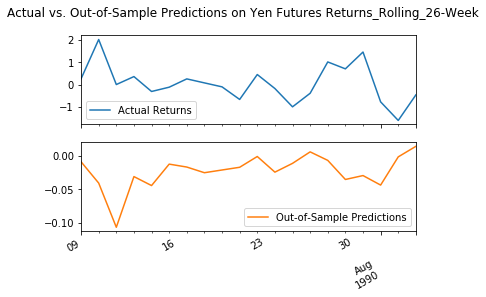

In [7243]:
# Plot the first 20 predictions vs the true values
Results[:20].plot(subplots=True, title='Actual vs. Out-of-Sample Predictions on Yen Futures Returns_Rolling_26-Week')

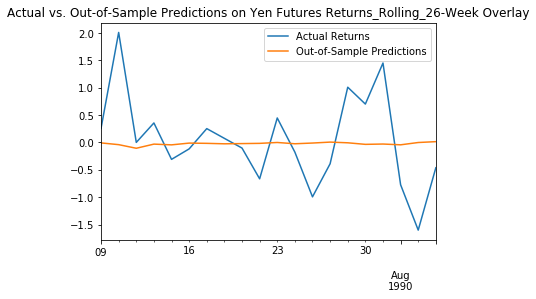

In [7244]:
# Plot the first 20 predictions vs the true values
Results[:20].plot(title='Actual vs. Out-of-Sample Predictions on Yen Futures Returns_Rolling_26-Week Overlay')

In [7245]:
mse_week27 = mean_squared_error(
    Results["Actual Returns"],
    Results["Out-of-Sample Predictions"]
)

# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
out_of_sample_rmse_week27 = np.sqrt(mse_week27)
print(f"Out-of-Sample Root Mean Squared Error (RMSE) of this seasonal rolling prediction: {out_of_sample_rmse_week27:,.4f}")

Out-of-Sample Root Mean Squared Error (RMSE) of this seasonal rolling prediction: 0.7000


In [7246]:
# Calculate r2_score (r-squared)
r2_week27_outofsample = r2_score(Results_seasonal["Actual Returns_Seasonal"], Results_seasonal["Out-of-Sample Predictions_Seasonal"])
print(f"r2: {r2_week27_outofsample}")

r2: -0.0031790262623399013


### _Returns on One-month Lags_

In [7247]:
yen_futures_seasonal.head()

,Return,Lagged_Return,Season
Date,,,
1990-01-04,1.756933,0.584197,1
1990-01-05,-0.827626,1.756933,1
1990-01-08,0.129496,-0.827626,1
1990-01-09,-0.632275,0.129496,1
1990-01-10,-0.404917,-0.632275,1


In [7248]:
yen_futures_seasoned = yen_futures_seasonal.resample('M').mean()
#yen_futures_seasoned = yen_futures_seasonal
yen_futures_seasoned.reset_index(inplace=True)
yen_futures_seasoned.head()

,Date,Return,Lagged_Return,Season
0,1990-01-31,0.039994,0.047493,1
1,1990-02-28,-0.167710,-0.134694,1
2,1990-03-31,-0.260589,-0.223251,2
3,1990-04-30,-0.026345,-0.092179,2
4,1990-05-31,0.191000,0.230178,2


In [7249]:
yen_futures_seasoned.set_index(['Date'], inplace=True)
yen_futures_seasoned.head()

,Return,Lagged_Return,Season
Date,,,
1990-01-31,0.039994,0.047493,1
1990-02-28,-0.167710,-0.134694,1
1990-03-31,-0.260589,-0.223251,2
1990-04-30,-0.026345,-0.092179,2
1990-05-31,0.191000,0.230178,2


In [7250]:
yen_futures_seasoned['Lagged_Returns']=yen_futures_seasoned['Return'].shift()
yen_futures_seasoned.drop(columns='Lagged_Return', inplace=True)
yen_futures_seasoned.dropna(inplace=True)
yen_futures_seasoned.head()

,Return,Season,Lagged_Returns
Date,,,
1990-02-28,-0.167710,1,0.039994
1990-03-31,-0.260589,2,-0.167710
1990-04-30,-0.026345,2,-0.260589
1990-05-31,0.191000,2,-0.026345
1990-06-30,0.010392,3,0.191000


In [7251]:
# Create a train/test split for the data using 2018-2019 for testing and the rest for training
# start from 1990-01-04 to drop rows with NaN in Return or Lagged_Return
# Create a train/test split for the data using 2018-2019 for testing and the rest for training
# start from 1990-01-04 to drop rows with NaN in Return or Lagged_Return
train_seasoned = yen_futures_seasoned['1990-02-28':'2017-12-31']
test_seasoned = yen_futures_seasoned['2018':]

In [7252]:
# Create four dataframes:
# X_train (training set using just the independent variables), X_test (test set of of just the independent variables)
# Y_train (training set using just the "y" variable, i.e., "Futures Return"), Y_test (test set of just the "y" variable):
X_train_seasoned = train_seasoned["Lagged_Returns"].dropna().to_frame()
X_test_seasoned = test_seasoned["Lagged_Returns"].dropna().to_frame()
y_train_seasoned = train_seasoned["Return"]
y_test_seasoned = test_seasoned["Return"]

In [7253]:
# Fit a SKLearn linear regression using just the training set (X_train, Y_train):
model_seasoned = LinearRegression()
model_seasoned.fit(X_train_seasoned, y_train_seasoned)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [7254]:
# Make a prediction of "y" values using just the test dataset
predictions_seasoned = model_seasoned.predict(X_test_seasoned)

In [7255]:
# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
Results_seasoned = y_test_seasoned.to_frame()
Results_seasoned["Predicted Return"] = predictions_seasoned
Results_seasoned.head(2)

,Return,Predicted Return
Date,,
2018-01-31,0.146016,0.005867
2018-02-28,0.113210,0.012874


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a5bb94610>,
      dtype=object)

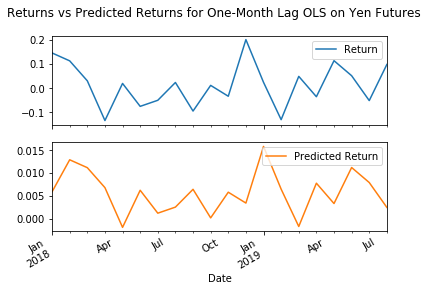

In [7256]:
# Plot the first 20 predictions vs the true values
Results_seasoned[:20].plot(subplots=True, 
                  title='Returns vs Predicted Returns for One-Month Lag OLS on Yen Futures')

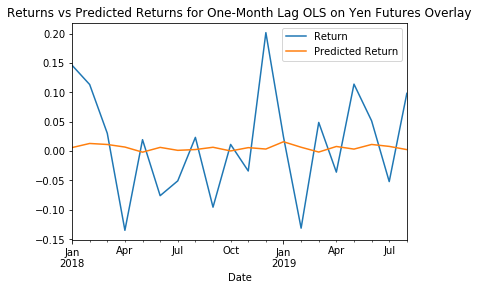

In [7257]:
# Plot the first 20 predictions vs the true values
Results_seasoned[:20].plot(title='Returns vs Predicted Returns for One-Month Lag OLS on Yen Futures Overlay')

In [7258]:
# Calculate the mean_squared_error (MSE) on actual versus predicted test "y" 
mse_seasoned = mean_squared_error(
    Results_seasoned["Return"],
    Results_seasoned["Predicted Return"]
)

# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
rmse_seasoned = np.sqrt(mse_seasoned)
print(f"Out-of-Sample Root Mean Squared Error (RMSE): {rmse_seasoned:,.4f}.")

Out-of-Sample Root Mean Squared Error (RMSE): 0.0888.


In [7259]:
# Calculate r2_score (r-squared)
r2_seasoned = r2_score(y_test_seasoned, predictions_seasoned)
print(f"r2: {r2_seasoned}")

r2: -0.008467889327852918


Text(0.5, 0.98, 'Out-of-Sample Performance for OLS Regression with One-Month Lag')

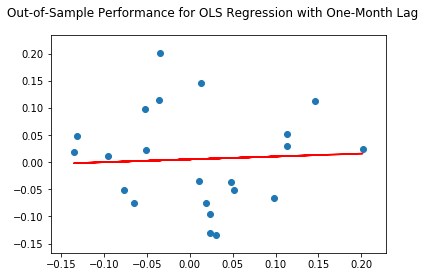

In [7260]:
# Plot X and y as a scatter plot
# Plot X and the predictions as a red line plot
plt.scatter(X_test_seasoned, y_test_seasoned)
plt.plot(X_test_seasoned, predictions_seasoned, color='red')
plt.suptitle('Out-of-Sample Performance for OLS Regression with One-Month Lag')

In [7261]:
# Construct a dataframe using just the "y" training data:
in_sample_results_seasoned = y_train_seasoned.to_frame()

# Add a column of "in-sample" predictions to that dataframe:  
in_sample_results_seasoned["In-sample Predictions"] = model_seasoned.predict(X_train_seasoned)

in_sample_results_seasoned.head(2)

,Return,In-sample Predictions
Date,,
1990-02-28,-0.167710,0.007288
1990-03-31,-0.260589,-0.003655


In [7262]:
# Calculate in-sample mean_squared_error (for comparison to out-of-sample)
in_sample_mse_seasoned = mean_squared_error(
    in_sample_results_seasoned["Return"],
    in_sample_results_seasoned["In-sample Predictions"]
)

# Calculate in-sample root mean_squared_error (for comparison to out-of-sample)
in_sample_rmse_seasoned = np.sqrt(in_sample_mse_seasoned)
print(f"In-sample Root Mean Squared Error (RMSE): {in_sample_rmse_seasoned:,.4f}.")

In-sample Root Mean Squared Error (RMSE): 0.1495.


In [7263]:
# Calculate r2_score (r-squared)
r2_seasoned = r2_score(y_train_seasoned, in_sample_results_seasoned["In-sample Predictions"])
print(f"r2: {r2_seasoned:,.4f}")

r2: 0.0028


Text(0.5, 0.98, 'In-Sample Performance')

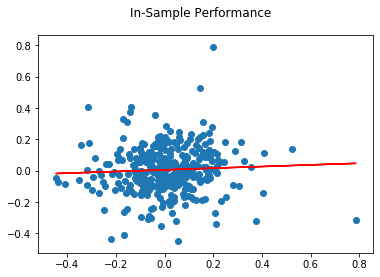

In [7264]:
# Plot X and y as a scatter plot
# Plot X and the predictions as a red line plot
plt.scatter(X_train_seasoned, y_train_seasoned)
plt.plot(X_train_seasoned, in_sample_results_seasoned["In-sample Predictions"], color='red')
plt.suptitle('In-Sample Performance')

### _Rolling Annual Regression_

In [7265]:
yen_futures_seasoned.head()

,Return,Season,Lagged_Returns
Date,,,
1990-02-28,-0.167710,1,0.039994
1990-03-31,-0.260589,2,-0.167710
1990-04-30,-0.026345,2,-0.260589
1990-05-31,0.191000,2,-0.026345
1990-06-30,0.010392,3,0.191000


In [7266]:
yen_futures_seasoned['Year'] = pd.DatetimeIndex(yen_futures_seasoned.index).year

In [7267]:
yen_futures_seasoned['Month'] = pd.DatetimeIndex(yen_futures_seasoned.index).month
yen_futures_seasoned.head()

,Return,Season,Lagged_Returns,Year,Month
Date,,,,,
1990-02-28,-0.167710,1,0.039994,1990,2
1990-03-31,-0.260589,2,-0.167710,1990,3
1990-04-30,-0.026345,2,-0.260589,1990,4
1990-05-31,0.191000,2,-0.026345,1990,5
1990-06-30,0.010392,3,0.191000,1990,6


In [7268]:
yen_futures_bymonth = yen_futures_seasoned.groupby([yen_futures_seasoned['Year'],yen_futures_seasoned['Month']]).mean()
yen_futures_bymonth.head()

Return  Season  Lagged_Returns  Year  Month
Year Month                                               
1990 2     -0.167710       1        0.039994  1990      2
     3     -0.260589       2       -0.167710  1990      3
     4     -0.026345       2       -0.260589  1990      4
     5      0.191000       2       -0.026345  1990      5
     6      0.010392       3        0.191000  1990      6

In [7269]:
yearMonths = yen_futures_bymonth.index.unique()
yearMonths

MultiIndex([(1990,  2),
            (1990,  3),
            (1990,  4),
            (1990,  5),
            (1990,  6),
            (1990,  7),
            (1990,  8),
            (1990,  9),
            (1990, 10),
            (1990, 11),
            ...
            (2019,  1),
            (2019,  2),
            (2019,  3),
            (2019,  4),
            (2019,  5),
            (2019,  6),
            (2019,  7),
            (2019,  8),
            (2019,  9),
            (2019, 10)],
           names=['Year', 'Month'], length=357)

In [7270]:
# Set the training window as 9 months, i.e. three quarters.
# The monthly rolling regression shows slightly better result, i.e. lower rmse than that of the 26 weeks'
# Total timeframe is 347 months
training_window_bymonth = 9
timeframe_bymonth = len(yearMonths) - training_window_bymonth - 1
timeframe_bymonth

347

In [7271]:
# Construct an empty placeholder DataFrame, with a column named "Out-of-Sample Predictions"
# (Each iteration of the loop, we'll append that week"s predictions to this DataFrame)
all_predictions_bymonth = pd.DataFrame(columns=["Out-of-Sample Predictions"])
all_predictions_bymonth

,Out-of-Sample Predictions


In [7272]:
# Construct a separate empty DataFrame for actual data
all_actuals_bymonth = pd.DataFrame(columns=["Actual Returns"])
all_actuals_bymonth

,Actual Returns


In [7273]:
for i in range(0, timeframe_bymonth):
    
    # Beginning of training window
    start_of_training_period_bymonth = yearMonths[i]
    
    # End of training window
    end_of_training_period_bymonth = yearMonths[training_window_bymonth + i]

    # Window of test-window data
    test_month = yearMonths[training_window_bymonth+i+1]
    
    # String of testing window
    start_of_test_month  = test_month
    end_of_test_month = test_month
    
    train_bymonth = yen_futures_bymonth[start_of_training_period_bymonth:end_of_training_period_bymonth]
    test_bymonth = yen_futures_bymonth[start_of_test_month:end_of_test_month]
    
    # Create new DataFrames:
    X_train_bymonth = train_bymonth["Lagged_Returns"].to_frame()
    y_train_bymonth = train_bymonth["Return"]
    X_test_bymonth = test_bymonth["Lagged_Returns"].to_frame()
    y_test_bymonth = test_bymonth["Return"]

    model_bymonth = LinearRegression()
    model_bymonth.fit(X_train_bymonth, y_train_bymonth)
    predictions_bymonth = model_bymonth.predict(X_test_bymonth)
        
    # Create a temporary DataFrame to hold predictions
    predictions_bymonth = pd.DataFrame(predictions_bymonth, index=X_test_bymonth.index, columns=["Out-of-Sample Predictions"])
    
    # Create a temporary DataFrame of the actual "y"s in the test DataFrame, with column name="Actual Returns": 
    actuals_bymonth = pd.DataFrame(y_test_bymonth, index=y_test_bymonth.index)
    actuals_bymonth.columns = ["Actual Returns"]  
    
    # Append these two DataFrames (predictions and actuals) to the two master DataFrames built outside the loop
    all_predictions_bymonth = all_predictions_bymonth.append(predictions_bymonth)
    all_actuals_bymonth = all_actuals_bymonth.append(actuals_bymonth)

In [7274]:
# Once the loop is done, concatenate (combine) the two DataFrames to a final "Results" DataFrame:    
Results_bymonth = pd.concat([all_actuals_bymonth, all_predictions_bymonth], axis=1)
Results_bymonth.head()

,Actual Returns,Out-of-Sample Predictions
"(1990, 12)",-0.100505,-0.001852
"(1991, 1)",0.144943,-0.000653
"(1991, 2)",-0.070200,0.092382
"(1991, 3)",-0.309092,0.114343
"(1991, 4)",0.174145,-0.054811


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a5c0c7690>,
      dtype=object)

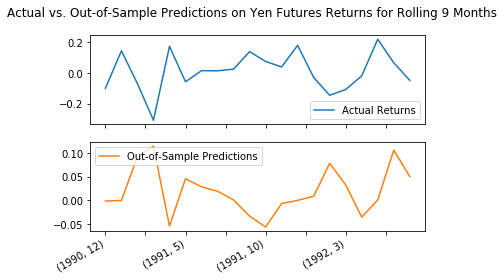

In [7275]:
# Plot the first 20 predictions vs the true values
Results_bymonth[:20].plot(subplots=True, title='Actual vs. Out-of-Sample Predictions on Yen Futures Returns for Rolling 9 Months')

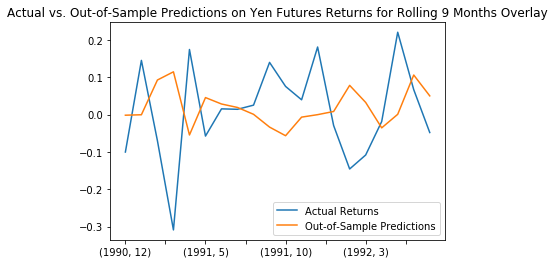

In [7276]:
# Plot the first 20 predictions vs the true values
Results_bymonth[:20].plot(title='Actual vs. Out-of-Sample Predictions on Yen Futures Returns for Rolling 9 Months Overlay')

In [7277]:
# Calculate the mean_squared_error (MSE) on actual versus predicted test "y" 
mse_bymonth = mean_squared_error(
    Results_bymonth["Actual Returns"],
    Results_bymonth["Out-of-Sample Predictions"]
)

# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
rmse_bymonth = np.sqrt(mse_bymonth)
print(f"Out-of-Sample Root Mean Squared Error (RMSE) of this monthly rolling prediction: {rmse_bymonth:,.4f}")

Out-of-Sample Root Mean Squared Error (RMSE) of this monthly rolling prediction: 0.1714


In [7278]:
# Calculate r2_score (r-squared)
r2_bymonth = r2_score(Results_bymonth["Actual Returns"], Results_bymonth["Out-of-Sample Predictions"])
print(f"r2: {r2_bymonth:,.4f}")

r2: -0.3794


### _Create a Regression with Seasonal Lag of One_

In [7279]:
yen_futures_byseason = yen_futures_seasoned.reset_index()
yen_futures_byseason.head(10)

,Date,Return,Season,Lagged_Returns,Year,Month
0,1990-02-28,-0.167710,1,0.039994,1990,2
1,1990-03-31,-0.260589,2,-0.167710,1990,3
2,1990-04-30,-0.026345,2,-0.260589,1990,4
3,1990-05-31,0.191000,2,-0.026345,1990,5
4,1990-06-30,0.010392,3,0.191000,1990,6
5,1990-07-31,0.195953,3,0.010392,1990,7
6,1990-08-31,0.064436,3,0.195953,1990,8
7,1990-09-30,0.195761,4,0.064436,1990,9
8,1990-10-31,0.280545,4,0.195761,1990,10
9,1990-11-30,-0.090269,4,0.280545,1990,11


In [7280]:
yen_futures_byseason=yen_futures_seasoned.groupby([yen_futures_seasoned['Year'],yen_futures_seasoned['Season']]).mean()
yen_futures_byseason.head()

Return  Lagged_Returns  Month
Year Season                                 
1990 1      -0.134107       -0.025138    7.0
     2      -0.031978       -0.151548    4.0
     3       0.090260        0.132448    7.0
     4       0.128679        0.180247   10.0
1991 1       0.085176        0.027953    5.0

In [7281]:
yen_futures_byseason['Lagged_Return'] = yen_futures_byseason['Return'].shift()
yen_futures_byseason.drop(columns=['Lagged_Returns','Month'], inplace=True)
yen_futures_byseason.dropna(inplace=True)

In [7282]:
yen_futures_byseason.head(10)

Return  Lagged_Return
Year Season                         
1990 2      -0.031978      -0.134107
     3       0.090260      -0.031978
     4       0.128679       0.090260
1991 1       0.085176       0.128679
     2      -0.064239       0.085176
     3       0.018066      -0.064239
     4       0.084745       0.018066
1992 1      -0.061413       0.084745
     2       0.030996      -0.061413
     3       0.058495       0.030996

In [7283]:
yen_futures_by_season = yen_futures_byseason.reset_index(inplace=True)
yen_futures_byseason.head()

,Year,Season,Return,Lagged_Return
0,1990,2,-0.031978,-0.134107
1,1990,3,0.090260,-0.031978
2,1990,4,0.128679,0.090260
3,1991,1,0.085176,0.128679
4,1991,2,-0.064239,0.085176


In [7284]:
yen_futures_byseason.set_index('Year', inplace=True)
yen_futures_byseason.head()

,Season,Return,Lagged_Return
Year,,,
1990,2,-0.031978,-0.134107
1990,3,0.090260,-0.031978
1990,4,0.128679,0.090260
1991,1,0.085176,0.128679
1991,2,-0.064239,0.085176


In [7285]:
# Create a train/test split for the data using 2018-2019 for testing and the rest for training
# Create a train/test split for the data using 2018-2019 for testing and the rest for training
train_byseason = yen_futures_byseason.loc['1990':'2017']
test_byseason = yen_futures_byseason.loc['2018':]

In [7286]:
train_byseason.tail()

,Season,Return,Lagged_Return
Year,,,
2016,4,-0.156221,0.109412
2017,1,0.067210,-0.156221
2017,2,0.023093,0.067210
2017,3,0.011755,0.023093
2017,4,-0.035942,0.011755


In [7287]:
test_byseason.head()

,Season,Return,Lagged_Return
Year,,,
2018,1,0.153581,-0.035942
2018,2,-0.028485,0.153581
2018,3,-0.034508,-0.028485
2018,4,-0.039431,-0.034508
2019,1,-0.053673,-0.039431


In [7288]:
# Xs are from Lagged_Return and Ys are on Return, for train and test time windows respectively
X_train_byseason = train_byseason["Lagged_Return"].dropna().to_frame()
X_test_byseason = test_byseason["Lagged_Return"].dropna().to_frame()
y_train_byseason = train_byseason["Return"]
y_test_byseason = test_byseason["Return"]

In [7289]:
# Fit a SKLearn linear regression using just the training set (X_train, Y_train):
model_byseason = LinearRegression()
model_byseason.fit(X_train_byseason, y_train_byseason)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [7290]:
# Make a prediction of "y" values using just the test dataset
predictions_byseason = model_byseason.predict(X_test_byseason)

In [7291]:
# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
Results_byseason = y_test_byseason.to_frame()
Results_byseason["Predicted Return"] = predictions_byseason
Results_byseason.head(2)

,Return,Predicted Return
Year,,
2018,0.153581,0.011097
2018,-0.028485,-0.010824


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a5c365750>,
      dtype=object)

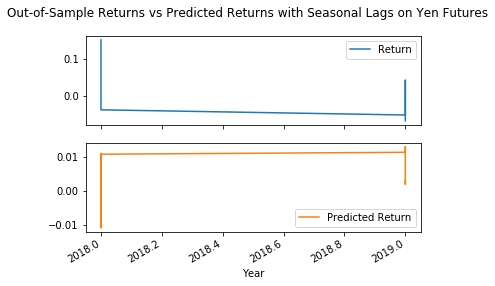

In [7292]:
# Plot the first 20 predictions vs the true values
Results_byseason[:20].plot(subplots=True, 
                  title='Out-of-Sample Returns vs Predicted Returns with Seasonal Lags on Yen Futures')

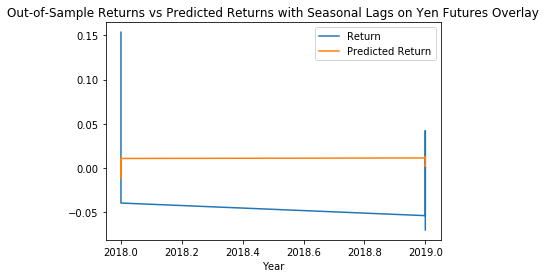

In [7293]:
Results_byseason[:20].plot(subplots=False, 
                  title='Out-of-Sample Returns vs Predicted Returns with Seasonal Lags on Yen Futures Overlay')

In [7294]:
# Calculate the mean_squared_error (MSE) on actual versus predicted test "y" 
mse_byseason = mean_squared_error(
    Results_byseason["Return"],
    Results_byseason["Predicted Return"]
)

# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
rmse_byseason = np.sqrt(mse_byseason)
print(f"Out-of-Sample Root Mean Squared Error (RMSE): {rmse_byseason:,.4f}.")

Out-of-Sample Root Mean Squared Error (RMSE): 0.0675.


In [7295]:
# Calculate r2_score (r-squared)
r2_byseason = r2_score(y_test_byseason, predictions_byseason)
print(f"r2: {r2_byseason}")

r2: 0.03280025539645637


Text(0.5, 0.98, 'Out-of-Sample Performance for Returns on Yen Futures with Seasonal Lags')

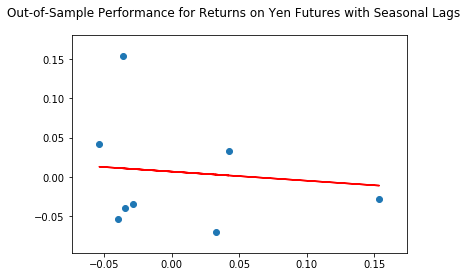

In [7296]:
# Plot X and y as a scatter plot
# Plot X and the predictions as a red line plot
plt.scatter(X_test_byseason, y_test_byseason)
plt.plot(X_test_byseason, predictions_byseason, color='red')
plt.suptitle('Out-of-Sample Performance for Returns on Yen Futures with Seasonal Lags')

In [7297]:
# Construct a dataframe using just the "y" training data:
in_sample_results_byseason = y_train_byseason.to_frame()

# Add a column of "in-sample" predictions to that dataframe:  
in_sample_results_byseason["In-sample Predictions"] = model_byseason.predict(X_train_byseason)

in_sample_results_byseason.head(2)

,Return,In-sample Predictions
Year,,
1990,-0.031978,0.022450
1990,0.090260,0.010638


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a5c6cf410>,
      dtype=object)

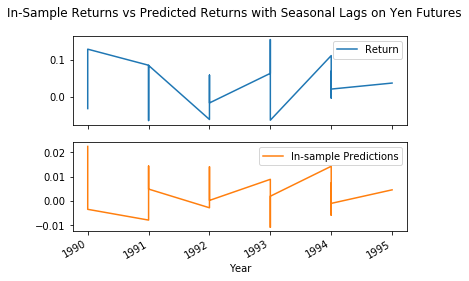

In [7298]:
# Plot the first 20 predictions vs the true values
in_sample_results_byseason[:20].plot(subplots=True, 
                  title='In-Sample Returns vs Predicted Returns with Seasonal Lags on Yen Futures')

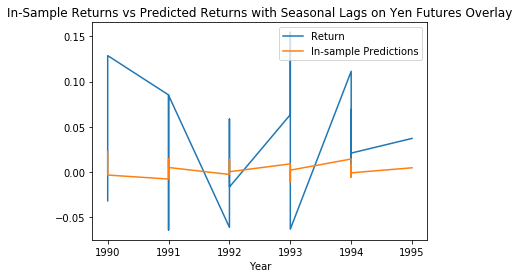

In [7299]:
# Plot the first 20 predictions vs the true values
in_sample_results_byseason[:20].plot( 
                  title='In-Sample Returns vs Predicted Returns with Seasonal Lags on Yen Futures Overlay')

In [7300]:
# Calculate in-sample mean_squared_error (for comparison to out-of-sample)
in_sample_mse_byseason = mean_squared_error(
    in_sample_results_byseason["Return"],
    in_sample_results_byseason["In-sample Predictions"]
)

# Calculate in-sample root mean_squared_error (for comparison to out-of-sample)
in_sample_rmse_byseason = np.sqrt(in_sample_mse_byseason)
print(f"In-sample Root Mean Squared Error (RMSE): {in_sample_rmse_byseason:,.4f}.")

In-sample Root Mean Squared Error (RMSE): 0.0910.


In [7301]:
# Calculate r2_score (r-squared)
r2_byseason = r2_score(y_train_byseason, in_sample_results_byseason["In-sample Predictions"])
print(f"r2: {r2_byseason:,.4f}")

r2: 0.0136


Text(0.5, 0.98, 'In-Sample Performance for Returns on Yen Futures with Seasonal Lags')

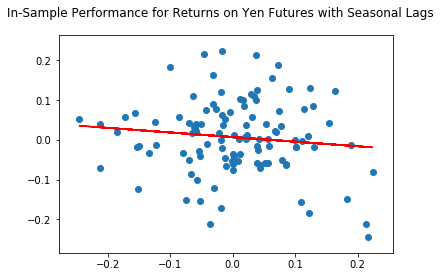

In [7302]:
# Plot X and y as a scatter plot
# Plot X and the predictions as a red line plot
plt.scatter(X_train_byseason, y_train_byseason)
plt.plot(X_train_byseason, in_sample_results_byseason["In-sample Predictions"], color='red')
plt.suptitle('In-Sample Performance for Returns on Yen Futures with Seasonal Lags')

### _Rolling Seasonal Regression_

In [7303]:
yen_futures_byseason.reset_index(inplace=True)
yen_futures_byseason.head()

,Year,Season,Return,Lagged_Return
0,1990,2,-0.031978,-0.134107
1,1990,3,0.090260,-0.031978
2,1990,4,0.128679,0.090260
3,1991,1,0.085176,0.128679
4,1991,2,-0.064239,0.085176


In [7304]:
yen_futures_byseason = yen_futures_byseason.groupby([yen_futures_byseason['Year'],yen_futures_byseason['Season']]).mean()

In [7305]:
yen_futures_byseason

Year  Season    Return  Lagged_Return
Year Season                                       
1990 2       1990       2 -0.031978      -0.134107
     3       1990       3  0.090260      -0.031978
     4       1990       4  0.128679       0.090260
1991 1       1991       1  0.085176       0.128679
     2       1991       2 -0.064239       0.085176
...           ...     ...       ...            ...
2018 4       2018       4 -0.039431      -0.034508
2019 1       2019       1 -0.053673      -0.039431
     2       2019       2  0.042214      -0.053673
     3       2019       3  0.032532       0.042214
     4       2019       4 -0.069816       0.032532

[119 rows x 4 columns]

In [7306]:
seasons = yen_futures_byseason.index.unique()
seasons

MultiIndex([(1990, 2),
            (1990, 3),
            (1990, 4),
            (1991, 1),
            (1991, 2),
            (1991, 3),
            (1991, 4),
            (1992, 1),
            (1992, 2),
            (1992, 3),
            ...
            (2017, 3),
            (2017, 4),
            (2018, 1),
            (2018, 2),
            (2018, 3),
            (2018, 4),
            (2019, 1),
            (2019, 2),
            (2019, 3),
            (2019, 4)],
           names=['Year', 'Season'], length=119)

In [7307]:
# Set the training window as 3 seasons, i.e. 3 quarters or approximately nine months
# The monthly rolling regression shows slightly better result, i.e. lower rmse than that of the 26 weeks'
# Total timeframe is 115 seasons
training_window_byseason = 3
timeframe_byseason = len(seasons) - training_window_byseason - 1
timeframe_byseason

115

In [7308]:
# Construct an empty placeholder DataFrame, with a column named "Out-of-Sample Predictions"
# (Each iteration of the loop, we'll append that week"s predictions to this DataFrame)
all_predictions_byseason = pd.DataFrame(columns=["Out-of-Sample Predictions"])
all_predictions_byseason

,Out-of-Sample Predictions


In [7309]:
# Construct a separate empty DataFrame for actual data
all_actuals_byseason = pd.DataFrame(columns=["Actual Returns"])
all_actuals_byseason

,Actual Returns


In [7310]:
for i in range(0, timeframe_byseason):
    
    # Beginning of training window
    start_of_training_period_byseason = seasons[i]
    
    # End of training window
    end_of_training_period_byseason = seasons[training_window_byseason + i]

    # Window of test-window data
    test_season = seasons[training_window_byseason+i+1]
    
    # String of testing window
    start_of_test_season  = test_season
    end_of_test_season = test_season
    
    train_byseason = yen_futures_byseason[start_of_training_period_byseason:end_of_training_period_byseason]
    test_byseason = yen_futures_byseason[start_of_test_season:end_of_test_season]
    
    # Create new DataFrames:
    X_train_byseason = train_byseason["Lagged_Return"].to_frame()
    y_train_byseason = train_byseason["Return"]
    X_test_byseason = test_byseason["Lagged_Return"].to_frame()
    y_test_byseason = test_byseason["Return"]

    model_byseason = LinearRegression()
    model_byseason.fit(X_train_byseason, y_train_byseason)
    predictions_byseason = model_byseason.predict(X_test_byseason)
        
    # Create a temporary DataFrame to hold predictions
    predictions_byseason = pd.DataFrame(predictions_byseason, index=X_test_byseason.index, columns=["Out-of-Sample Predictions"])
    
    # Create a temporary DataFrame of the actual "y"s in the test DataFrame, with column name="Actual Returns": 
    actuals_byseason = pd.DataFrame(y_test_byseason, index=y_test_byseason.index)
    actuals_byseason.columns = ["Actual Returns"]  
    
    # Append these two DataFrames (predictions and actuals) to the two master DataFrames built outside the loop
    all_predictions_byseason = all_predictions_byseason.append(predictions_byseason)
    all_actuals_byseason = all_actuals_byseason.append(actuals_byseason)

In [7311]:
# Once the loop is done, concatenate (combine) the two DataFrames to a final "Results" DataFrame:    
Results_byseason = pd.concat([all_actuals_byseason, all_predictions_byseason], axis=1)
Results_byseason.head()

,Actual Returns,Out-of-Sample Predictions
"(1991, 2)",-0.064239,0.102132
"(1991, 3)",0.018066,0.079194
"(1991, 4)",0.084745,0.030554
"(1992, 1)",-0.061413,0.032292
"(1992, 2)",0.030996,0.053147


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a5ca127d0>,
      dtype=object)

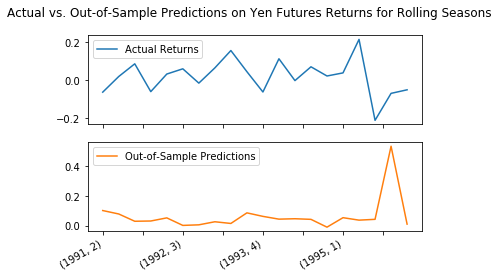

In [7312]:
# Plot the first 20 predictions vs the true values
Results_byseason[:20].plot(subplots=True, title='Actual vs. Out-of-Sample Predictions on Yen Futures Returns for Rolling Seasons')

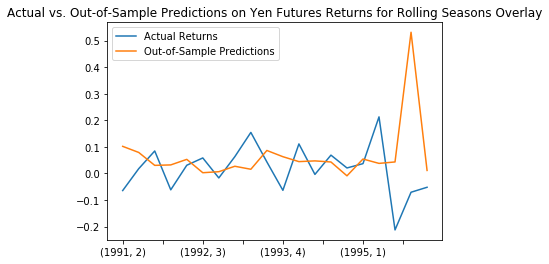

In [7313]:
# Plot the first 20 predictions vs the true values
Results_byseason[:20].plot(title='Actual vs. Out-of-Sample Predictions on Yen Futures Returns for Rolling Seasons Overlay')

In [7314]:
# Calculate the mean_squared_error (MSE) on actual versus predicted test "y" 
mse_byseason = mean_squared_error(
    Results_byseason["Actual Returns"],
    Results_byseason["Out-of-Sample Predictions"]
)

# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
rmse_byseason = np.sqrt(mse_byseason)
print(f"Out-of-Sample Root Mean Squared Error (RMSE) of this seasonal rolling prediction: {rmse_byseason:,.4f}")

Out-of-Sample Root Mean Squared Error (RMSE) of this seasonal rolling prediction: 0.1286


In [7315]:
# Calculate r2_score (r-squared)
r2_byseason = r2_score(Results_byseason["Actual Returns"], Results_byseason["Out-of-Sample Predictions"])
print(f"r2: {r2_byseason:,.4f}")

r2: -1.0262


#### _Set Rolling Multiple Training Seasons_

In [7316]:
# Set the training window as 7 seasons, i.e. 2 quarters or approximately nine months
# The monthly rolling regression shows slightly better result, i.e. lower rmse than that of the 26 weeks'
# Total timeframe is 111 seasons
training_window_byseason = 7
timeframe_byseason = len(seasons) - training_window_byseason - 1
timeframe_byseason

111

In [7317]:
# Construct an empty placeholder DataFrame, with a column named "Out-of-Sample Predictions"
# (Each iteration of the loop, we'll append that week"s predictions to this DataFrame)
all_predictions_byseason = pd.DataFrame(columns=["Out-of-Sample Predictions"])
all_predictions_byseason

,Out-of-Sample Predictions


In [7318]:
# Construct a separate empty DataFrame for actual data
all_actuals_byseason = pd.DataFrame(columns=["Actual Returns"])
all_actuals_byseason

,Actual Returns


In [7319]:
for i in range(0, timeframe_byseason):
    
    # Beginning of training window
    start_of_training_period_byseason = seasons[i]
    
    # End of training window
    end_of_training_period_byseason = seasons[training_window_byseason + i]

    # Window of test-window data
    test_season = seasons[training_window_byseason+i+1]
    
    # String of testing window
    start_of_test_season  = test_season
    end_of_test_season = test_season
    
    train_byseason = yen_futures_byseason[start_of_training_period_byseason:end_of_training_period_byseason]
    test_byseason = yen_futures_byseason[start_of_test_season:end_of_test_season]
    
    # Create new DataFrames:
    X_train_byseason = train_byseason["Lagged_Return"].to_frame()
    y_train_byseason = train_byseason["Return"]
    X_test_byseason = test_byseason["Lagged_Return"].to_frame()
    y_test_byseason = test_byseason["Return"]

    model_byseason = LinearRegression()
    model_byseason.fit(X_train_byseason, y_train_byseason)
    predictions_byseason = model_byseason.predict(X_test_byseason)
        
    # Create a temporary DataFrame to hold predictions
    predictions_byseason = pd.DataFrame(predictions_byseason, index=X_test_byseason.index, columns=["Out-of-Sample Predictions"])
    
    # Create a temporary DataFrame of the actual "y"s in the test DataFrame, with column name="Actual Returns": 
    actuals_byseason = pd.DataFrame(y_test_byseason, index=y_test_byseason.index)
    actuals_byseason.columns = ["Actual Returns"]  
    
    # Append these two DataFrames (predictions and actuals) to the two master DataFrames built outside the loop
    all_predictions_byseason = all_predictions_byseason.append(predictions_byseason)
    all_actuals_byseason = all_actuals_byseason.append(actuals_byseason)

In [7320]:
# Once the loop is done, concatenate (combine) the two DataFrames to a final "Results" DataFrame:    
Results_byseason = pd.concat([all_actuals_byseason, all_predictions_byseason], axis=1)
Results_byseason.head()

,Actual Returns,Out-of-Sample Predictions
"(1992, 2)",0.030996,0.019545
"(1992, 3)",0.058495,0.039043
"(1992, 4)",-0.016724,0.035725
"(1993, 1)",0.063333,0.024788
"(1993, 2)",0.154549,-0.012451


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a5cd283d0>,
      dtype=object)

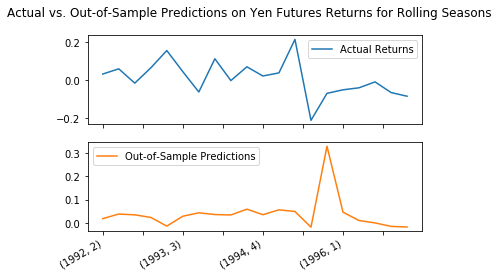

In [7321]:
# Plot the first 20 predictions vs the true values
Results_byseason[:20].plot(subplots=True, title='Actual vs. Out-of-Sample Predictions on Yen Futures Returns for Rolling Seasons')

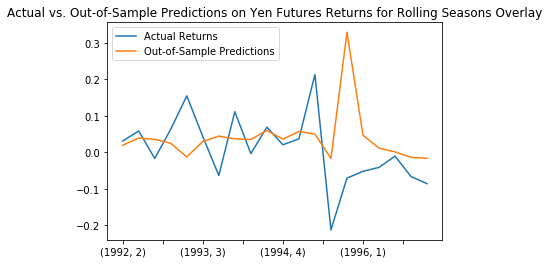

In [7322]:
# Plot the first 20 predictions vs the true values
Results_byseason[:20].plot(title='Actual vs. Out-of-Sample Predictions on Yen Futures Returns for Rolling Seasons Overlay')

In [7323]:
# Calculate the mean_squared_error (MSE) on actual versus predicted test "y" 
mse_byseason = mean_squared_error(
    Results_byseason["Actual Returns"],
    Results_byseason["Out-of-Sample Predictions"]
)

# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
rmse_byseason = np.sqrt(mse_byseason)
print(f"Out-of-Sample Root Mean Squared Error (RMSE) of this seasonal rolling prediction: {rmse_byseason:,.4f}")

Out-of-Sample Root Mean Squared Error (RMSE) of this seasonal rolling prediction: 0.1052


In [7324]:
# Calculate r2_score (r-squared)
r2_byseason = r2_score(Results_byseason["Actual Returns"], Results_byseason["Out-of-Sample Predictions"])
print(f"r2: {r2_byseason:,.4f}")

r2: -0.3315
